In [1]:
# Калькуляторы для AB тестирования: https://www.evanmiller.org/ab-testing/chi-squared.html

In [40]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from scipy.stats import binom_test
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

In [35]:
# План воркшопа
# 1. Пример с долей довольных покупателей
# 2. Пример с конверсией лендинга
# 3. Аналогичная модель, что и в п. 2, но на примере своих данных
# 4. Ошибки первого рода и alpha
# 5. Ошибки второго рода и мощность
# 6. Зачем нужны alpha и мощность

In [36]:
# 1. Пример с Виноградным днем. Менеджер утверждает, что 80% покупателей довольны напитком. Мы опросили 100 человек,
# 75 ответили, что напиток им нравится
print('=======1========')
# My solution
# Input data
sample_size = 100
sample_proportion = 0.75
true_population_proportion = 0.80
a = 1.96

=======1========


In [37]:
# Output
standard_error = (sample_proportion * (1 - sample_proportion) / sample_size) ** 0.5
print('standard_error:', standard_error)
margin_error = a * standard_error
print('margin_error:', margin_error)
lower_value = sample_proportion - margin_error
upper_value = sample_proportion + margin_error
print('lower_value:', lower_value)
print('upper_value:', upper_value)
if lower_value <= true_population_proportion <= upper_value:
    print('Менеджер не врет')
else:
    print('Менеджер врет')

standard_error: 0.04330127018922193
margin_error: 0.08487048957087498
lower_value: 0.665129510429125
upper_value: 0.834870489570875
Менеджер не врет


In [39]:
# Lecturer solution
# Сгенерируем случайную выборку в соответствии с вводными: вероятность = 0.8, наблюдений = 100, биномиальное распределение
sample = np.random.binomial(1, 0.8, 100)
# Посчитаем количество успешных результатов, выпавших единичек
sample_mean = np.mean(sample)
print('sample_mean:', sample_mean)
# Сравним полученный результат X c k = 75
# Если X <= k, то увеличим Y на 1
# Повторим
p_value = np.mean([np.random.binomial(1, 0.8, 100).mean() <= sample_proportion for i in range(10000)])
print('p_value:', p_value)
print('p_value binom_test:', binom_test(75, n=sample_size, p=0.8,  alternative='less'))
print('p_value proportions_ztest:', proportions_ztest(75, 100, value=0.8, alternative='smaller')[1])

# Вероятность получить 75% составляет 13%. Принимаем H0

sample_mean: 0.84
p_value: 0.1279
p_value binom_test: 0.13135321733298844
p_value proportions_ztest: 0.12410653949496159


In [55]:
#  2. Пример с лендингом. Провели AB: контрольная выборка: 700 пользователей, 300 экспериментальная группа,
# 70 конверсий в первой, 48 во второй.
print('=======2========')

# Создаем таблицу с результатами теста
data = pd.DataFrame({'Group': ['old landing (A)', 'new landing (B)'], 'Users': [700, 300], 'Sales': [70, 48]})

# Считаем процент конверсии
data['CR'] = data['Sales'] / data['Users']
print(data)

=======2========
             Group  Users  Sales    CR
0  old landing (A)    700     70  0.10
1  new landing (B)    300     48  0.16


In [56]:
# Формулируем HO: На самом деле показатель конверсии не отличается. Какая вероятность получить такие же и
# более значимые различия между двумя вариантами?

# Считаем, что не было разделения на группы. Добавляем в таблицу строку с общими результатами
data.loc['Total'] = data.sum()
data['CR'] = data['Sales'] / data['Users']
print(data)

                                Group  Users  Sales     CR
0                     old landing (A)    700     70  0.100
1                     new landing (B)    300     48  0.160
Total  old landing (A)new landing (B)   1000    118  0.118


In [57]:
# Создаем математическую модель.
# С помощью генератора случайных выборок с биномиальным распределением генерируем выборки.

In [58]:
# np.random.binomial(количество попыток, вероятность успеха, количество повторений)
# np.random.binomial(10, 0.5, 100)
# подбрасываем монетку 10 раз, с 50% вероятностью выпасти орлу или решке и повторяем 100 раз

# Среднее для контрольной выборки
# (1, 0,118, 700)
control_sample_mean = np.random.binomial(1, data.iat[2, 3], data.iat[0, 1]).mean()
print('control_sample_mean:', control_sample_mean)

# Среднее для тестовой выборки
# (1, 0,118, 300)
treatment_sample_mean = np.random.binomial(1, data.iat[2, 3], data.iat[1, 1]).mean()
print('treatment_sample_mean:', treatment_sample_mean)

# Считаем фактическую разницу между средними групп A и B. Считаем в обе стороны, поэтому добавляем модуль.
ab_mean_diff = abs(data.iat[0, 3] - data.iat[1, 3])
print('ab_mean_diff:', ab_mean_diff)

control_sample_mean: 0.12285714285714286
treatment_sample_mean: 0.13333333333333333
ab_mean_diff: 0.06


In [59]:
# Находим вероятность того, что разница в конверсии может быть больше или равна фактической разнице.
# Создаем функцию, которая будет генерировать разницу между средними выборок. Разницу считаем в обе стороны.
# Для этого добавляем модуль.

np.mean([abs(np.random.binomial(1,0.118,size=300).mean()
- np.random.binomial(1,0.118,size=700).mean()) >= 0.06 for _ in range(10000)])

0.0077

In [51]:
def sample_generator():
    mean_diff = abs(np.random.binomial(1, data.iat[2, 3], data.iat[0, 1]).mean()
                    - np.random.binomial(1, data.iat[2, 3], data.iat[1, 1]).mean())
    return mean_diff

In [53]:
# Генерируем 1 000 000 выборок
p_value = np.mean([sample_generator() >= ab_mean_diff for _ in range(1000000)])
print('p_value:', p_value)

p_value: 0.007216


In [60]:
# Проверяем результат с помощью Z-теста. Подаем на вход два массива: 1 с кол-вом продаж, второй с размерами выборок
# proportions_ztest(group A count of orders, group B count of orders, group A users, group B users)
p_value_z = proportions_ztest([data.iat[0, 2], data.iat[1, 2]], [data.iat[0, 1], data.iat[1, 1]])
print('p_value_1:', p_value_z[1])

p_value_1: 0.007035346384355496


In [61]:
# Проверяем результат с помощью теста Хи квадрат Пирсона.
# Создадим массив, где [[вариант A продажи, вариант A пользователи без покупок],
# [вариант B продажи, вариант B пользователи без покупок]]
data_array = [[data.iat[0, 2], data.iat[0, 1] - data.iat[0, 2]], [data.iat[1, 2], data.iat[1, 1] - data.iat[1, 2]]]
# chi2, p_value_chi2, dof, ex = chi2_contingency(data_array, correction=False)
p_value_chi2 = chi2_contingency(data_array, correction=False)
print('p_value_chi2:', p_value_chi2[1])
# Вывод: вероятность менее 1% (0.7%), отвергаем H0, делаем вывод, что разница в конверсии статистически значимая.

p_value_chi2: 0.00703534638435549


In [63]:
pd.DataFrame(data_array)

,0,1
0,70,630
1,48,252


In [24]:
# 3. Делаем аналогичный тест, но уже со своими данными
print('=======3========')
my_data = pd.DataFrame({'Group': ['old order form (A)', 'new order form (B)'], 'Users': [18632, 25032], 'Orders': [169, 188]})
my_data['CR'] = my_data['Orders'] / my_data['Users']
my_data.loc['Total'] = my_data.sum()
my_data['CR'] = my_data['Orders'] / my_data['Users']
print(my_data)
control_sample_mean = np.random.binomial(1, my_data.iat[2, 3], my_data.iat[0, 1]).mean()
treatment_sample_mean = np.random.binomial(1, my_data.iat[2, 3], my_data.iat[1, 1]).mean()
ab_mean_diff = abs(my_data.iat[0, 3] - my_data.iat[1, 3])

=======3========
                                      Group  Users  Orders        CR
0                        old order form (A)  18632     169  0.009070
1                        new order form (B)  25032     188  0.007510
Total  old order form (A)new order form (B)  43664     357  0.008176


In [25]:
def sample_generator():
    mean_diff = abs(np.random.binomial(1, my_data.iat[2, 3], my_data.iat[0, 1]).mean()
                    - np.random.binomial(1, my_data.iat[2, 3], my_data.iat[1, 1]).mean())
    return mean_diff

In [26]:
p_value = np.mean([sample_generator() >= ab_mean_diff for _ in range(10000)])
print('p_value:', p_value)
# proportions_ztest(group A count of orders, group B count of orders, group A users, group B users)
p_value_z = proportions_ztest([my_data.iat[0, 2], my_data.iat[1, 2]], [my_data.iat[0, 1], my_data.iat[1, 1]])
print('p_value_1:', p_value_z[1])
# data_array group A count of orders, group A users without orders, group B count of orders,
# group B users without orders
data_array = [[my_data.iat[0, 2], my_data.iat[0, 1] - my_data.iat[0, 2]], [my_data.iat[1, 2], my_data.iat[1, 1]
                                                                           - my_data.iat[1, 2]]]
p_value_chi2 = chi2_contingency(data_array, correction=False)
print('p_value_chi2:', p_value_chi2[1])
# Вывод: вероятность более 7% (7.69%), подтверждаем H0, делаем вывод, что разница в конверсии не статистически значимая.

p_value: 0.0787
p_value_1: 0.07338371350618815
p_value_chi2: 0.0733837135061886


In [27]:
# 4. Ошибки первого рода — это когда мы отвергаем верную нулевую гипотезу. Например, конверсия не отличается, но
# в результате тестов мы получаем статистические данные, которые показывают, что есть отличие.
# Значение alpha показывает вероятность того, что мы ошибочно отклоним верную нулевую гипотезу. Как правило,
# используют alpha = 0.05, но при реальных тестах используют значение меньше.
print('=======4========')

=======4========


alpha probability: 0.045


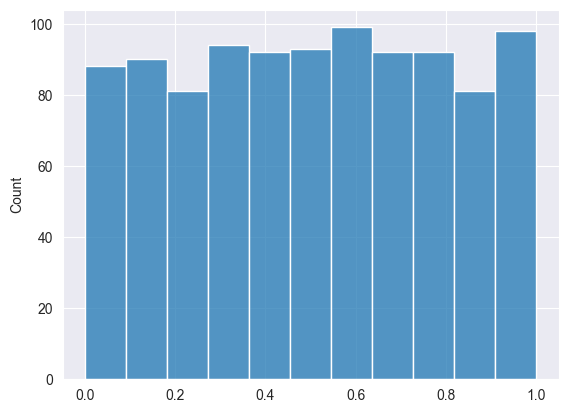

In [28]:
# Проверим достоверность уровня статистической значимости alpha
n = 1000
result = []
for _ in range(n):
    a = np.random.binomial(1, 0.118, size=700)
    b = np.random.binomial(1, 0.118, size=300)
    diff = abs(a.mean() - b.mean())
    null_hyp_prob = np.concatenate([a, b]).mean()
    p_val = np.mean([abs(np.random.binomial(1, null_hyp_prob, size=300).mean()
                         - np.random.binomial(1, null_hyp_prob, size=700).mean()) >= diff for _ in range(1000)])
    result.append(p_val)
print('alpha probability:', (np.array(result) < 0.05).mean())

# Если между конверсией двух выборок нет разницы, то p-value на гистограмме будет распределяться равномерно
sns.histplot(result)
plt.show()

In [29]:
# 5. Ошибки второго рода — это когда мы принимаем неверную нулевую гипотезу. Например, на самом деле конверсия
# отличается, но в результате тестов мы получаем статистику, которая говорит, что отличий нет.
# Мощность показывает вероятность того, что мы отклоним неверную нулевую гипотезу (подтвердим верную альтернативную т.е.
# вероятность найти реально существующие различия между A и B). Обычно используют мощность равную 0.8
print('=======5========')

=======5========


power probability: 0.754


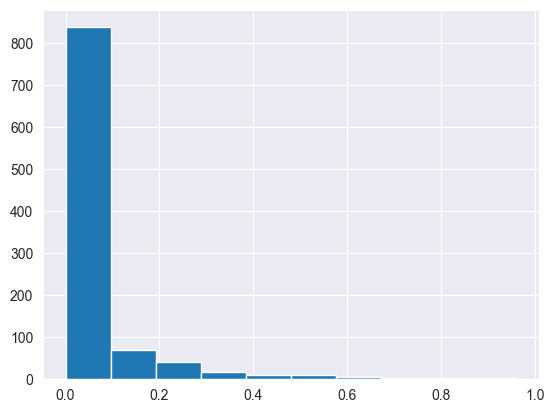

In [30]:
# Проверим вероятность подтвердить неверную нулевую гипотезу. Сгенерируем выборки, в которых средние отличаются.
n = 1000
result = []
for _ in range(n):
    a = np.random.binomial(1, 0.10, size=700)
    b = np.random.binomial(1, 0.16, size=300)
    diff = abs(a.mean() - b.mean())
    null_hyp_prob = np.concatenate([a, b]).mean()
    p_val = np.mean([abs(np.random.binomial(1, null_hyp_prob, size=300).mean()
                         - np.random.binomial(1, null_hyp_prob, size=700).mean()) >= diff for _ in range(1000)])
    result.append(p_val)
print('power probability:', (np.array(result) < 0.05).mean())
# Обрати внимание, что P-value распределяется неравномерно, большая часть значений близка к нулю.
# Это нормальное поведение для отличающихся средних.
pd.Series(result).hist()
plt.show()

In [31]:
# Расчет размера выборки:
# effectsize(0.10, 0.15) это ожидаемый эффект. 0.10 текущая конверсия, 0.15 планируемая конверсия
es = sms.proportion_effectsize(0.10, 0.15)
# ratio соотношение выборок
print('Размер выборки:', sms.NormalIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1))
# Калькулятор размера выборки: https://www.evanmiller.org/ab-testing/sample-size.html

Размер выборки: 680.3526619127882


In [32]:
# 6. Alpha и мощность позволяют учесть вероятность ошибок первого и второго рода, учесть их в модели,
# рассчитать необходимое количество наблюдений в выборке.

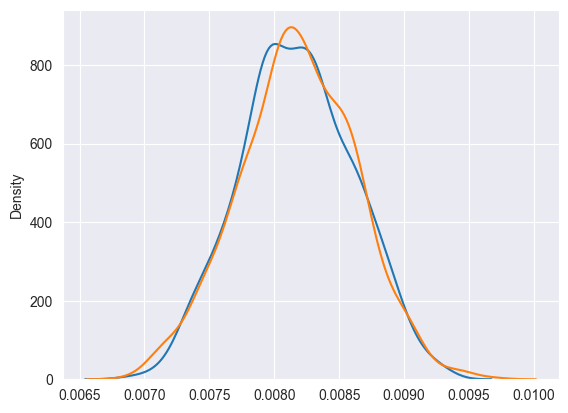

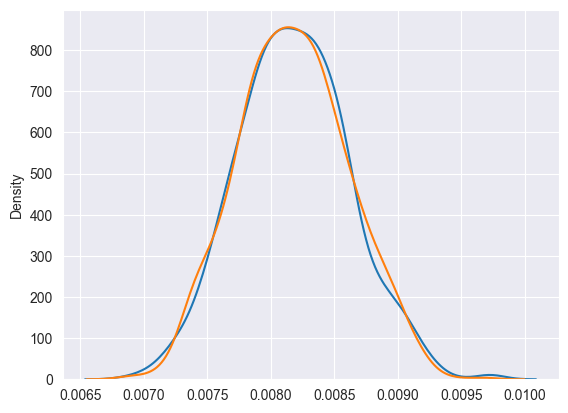

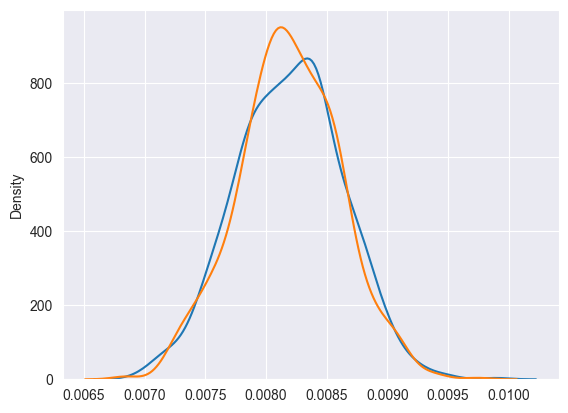

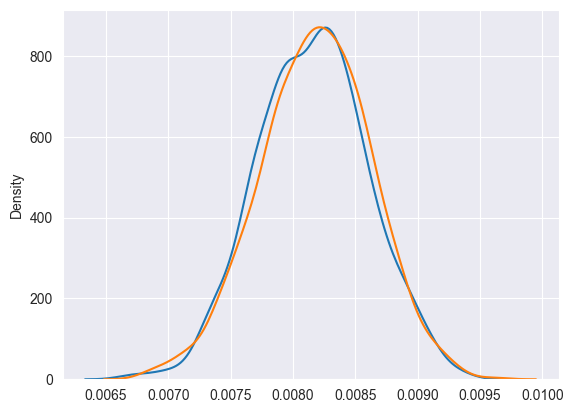

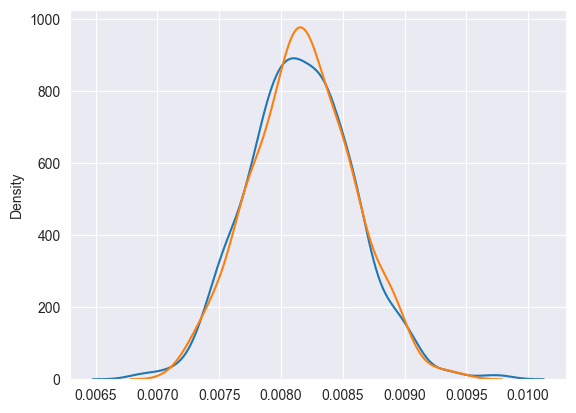

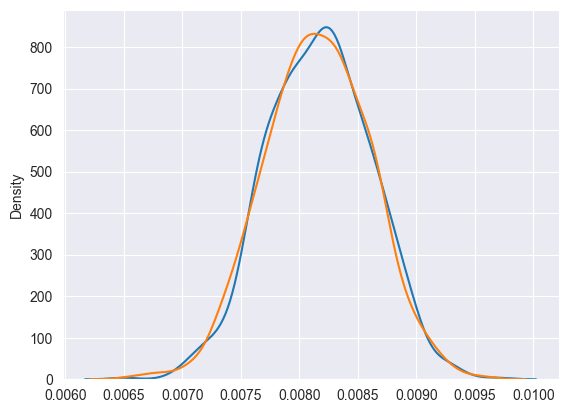

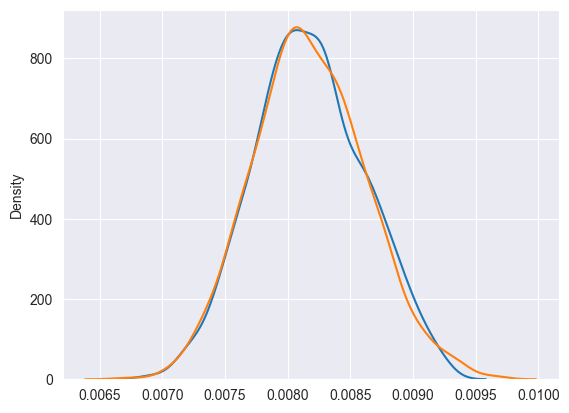

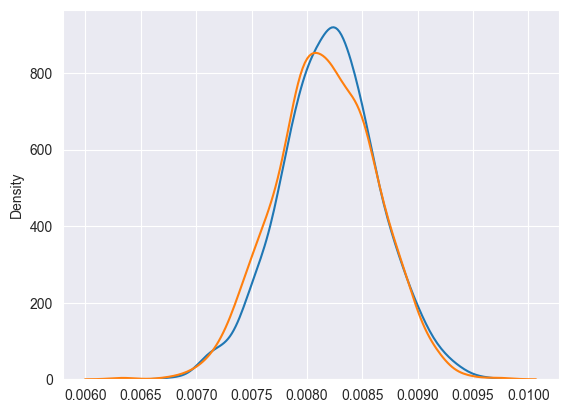

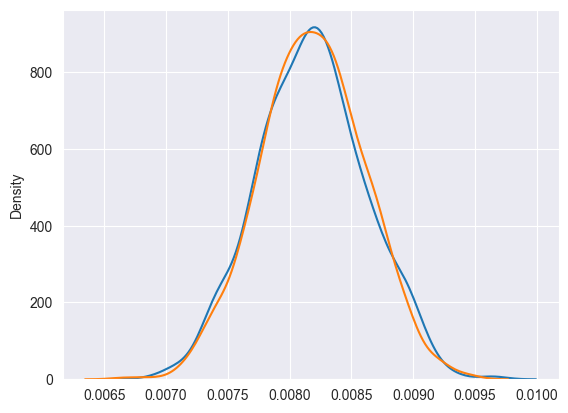

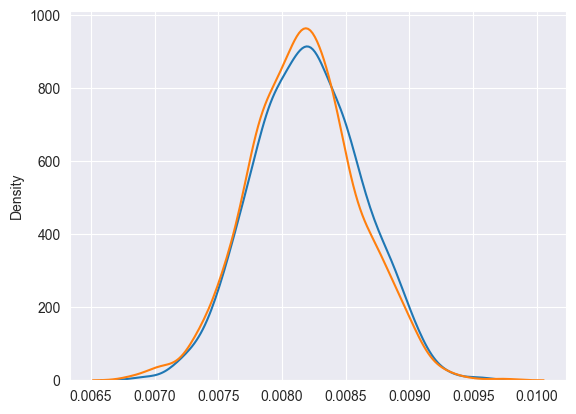

In [33]:
# 7. Бонус. Сравнение получаемых гистограмм для нормального и биномиального распределения
for _ in range(10):
    result = []
    for _ in range(1000):
        a = np.random.binomial(1, 0.008176, size=43664).mean()
        result.append(a)
    result_std = np.std(result)

    b = np.random.normal(0.008176, result_std, 1000).tolist()
    sns.kdeplot(result)
    sns.kdeplot(b)
    plt.show()